In [1]:
from huggingface_hub import hf_hub_download
from datasets import Dataset

parquet_path = hf_hub_download(
    repo_id="diffusers-internal-dev/ShotDEAD", filename="shard_00000.parquet", repo_type="dataset"
)
ds = Dataset.from_parquet(parquet_path)
ds

Dataset({
    features: ['id', 'colors', 'details', 'image'],
    num_rows: 5000
})

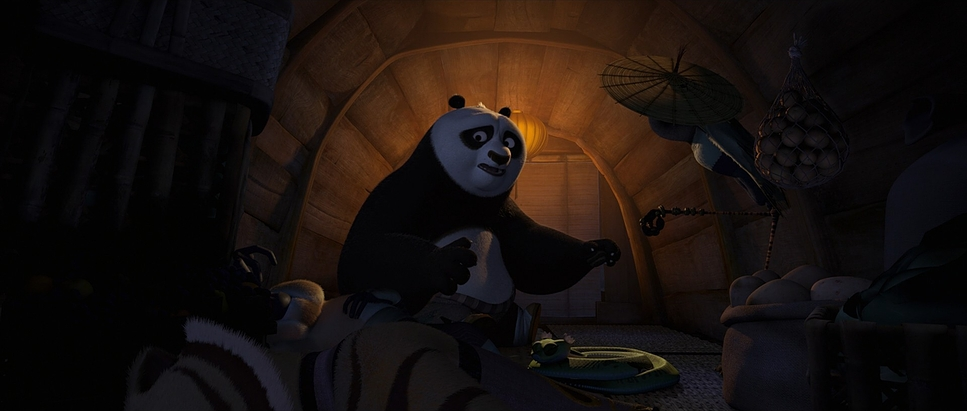

In [2]:
from PIL import Image 
import io

Image.open(io.BytesIO(ds[10]["image"]))

In [3]:
from pprint import pprint
import json

pprint(json.loads(ds[0]["details"]))

{'Actors': ['Christian Bale'],
 'Aspect Ratio': ['2.35', 'Spherical'],
 'Camera': ['Panavision Cameras'],
 'Cinematographer': ['Andrzej Sekula'],
 'Color': ['Blue'],
 'Colorist': ['Chris Hinton'],
 'Composition': ['Left heavy'],
 'Costume Designer': ['Isis Mussenden'],
 'Director': ['Mary Harron'],
 'Editor': ['Andrew Marcus'],
 'Film Stock / Resolution': ['Fuji F-CP 3519'],
 'Filming Location': ['Earth',
                      'North America',
                      'Canada',
                      'Ontario',
                      'Toronto',
                      '...',
                      'Ontario',
                      'Toronto'],
 'Format': ['Film - 35mm'],
 'Frame Size': ['Medium'],
 'Genre': ['Crime', 'Drama'],
 'Interior/Exterior': ['Interior'],
 'Lens': ['Panavision Lenses'],
 'Lens Size': ['Medium'],
 'Lighting': ['Soft light'],
 'Lighting Type': ['Daylight'],
 'Location Type': ['Location'],
 'Production Designer': ['Gideon Ponte'],
 'Set': ['Apartment Building', 'Home', 'Livi

In [4]:
json.loads(ds[0]["details"]).keys()

dict_keys(['Tags', 'Genre', 'Director', 'Cinematographer', 'Production Designer', 'Costume Designer', 'Editor', 'Colorist', 'Actors', 'Shot Time', 'Time Period', 'Color', 'Aspect Ratio', 'Format', 'Frame Size', 'Shot Type', 'Lens Size', 'Composition', 'Lighting', 'Lighting Type', 'Time of Day', 'Interior/Exterior', 'Location Type', 'Set', 'Story Location', 'Filming Location', 'Camera', 'Lens', 'Film Stock / Resolution'])

In [5]:
none_key_map = {
    "Color": ["no_color"],
    "Lighting": ["no_lighting"],
    "Lighting Type": ["no_ligting_type"],
    "Composition": ["no_composition"],
}

def deduce_captions(row):
    details = json.loads(row["details"])

    def get_detail(key):
        value = details.get(key)
        if value:
            if isinstance(value, list):
                # Join multiple values into a comma-separated string.
                return ", ".join(value)
            return str(value)
        else:
            # Use a fallback default, optionally replacing placeholders to sound more natural.
            default = none_key_map[key][0]
            return default.replace("no_", "unspecified ").replace("_", " ")

    # Extract details.
    reduced_dict = {}
    for k in none_key_map:
        reduced_dict.update({k: get_detail(k)})

    # Craft a natural language caption.
    json_string = json.dumps(reduced_dict)
    caption = f"""This image has the following shot details:

```json
{json_string}
```
"""

    row["caption"] = caption
    return row



reduced_ds = ds.map(deduce_captions, num_proc=4)
reduced_ds

Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'colors', 'details', 'image', 'caption'],
    num_rows: 5000
})

In [6]:
reduced_ds[100]["caption"]

'This image has the following shot details:\n\n```json\n{"Color": "Warm, Desaturated, Yellow", "Lighting": "Hard light, Side light", "Lighting Type": "Daylight, Practical light, Mixed light", "Composition": "Center"}\n```\n'

In [13]:
def prepare_conversations(row):
    row["messages"] = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Provide the shot details of the image"},
                {"type": "image"}
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": row["caption"]}
            ]
        }
    ]
    return row


reduced_ds_with_messages = reduced_ds.map(prepare_conversations, num_proc=4)
reduced_ds_with_messages

Map (num_proc=4):   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'colors', 'details', 'image', 'caption', 'messages'],
    num_rows: 5000
})

In [14]:
reduced_ds_with_messages[0]["messages"]

[{'content': [{'text': 'Provide the shot details of the image',
    'type': 'text'},
   {'text': None, 'type': 'image'}],
  'role': 'user'},
 {'content': [{'text': 'This image has the following shot details:\n\n```json\n{"Color": "Blue", "Lighting": "Soft light", "Lighting Type": "Daylight", "Composition": "Left heavy"}\n```\n',
    'type': 'text'}],
  'role': 'assistant'}]

Follow this guide to fine-tune a VLM (PaliGemma?), following [this guide](https://huggingface.co/docs/trl/en/sft_trainer#extending-sfttrainer-for-vision-language-models).